<a href="https://colab.research.google.com/github/iesous-kurios/DS-Unit-2-Applied-Modeling/blob/master/module4/BuildWeekProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'


In [0]:
# all imports needed for this sheet

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [0]:
df = pd.read_excel('/content/pipeline_pickle.xlsx')

I chose "exit to permanent" housing as my target due to my belief that accurately predicting this feature would have the largest impact on actual people experiencing homelessness in my county.  Developing and fine tuning an accurate model with our data could also lead to major improvements in our county's efforts at addressing the homelessness problem among singles as well (as our shelter only serves families)

In [0]:
exit_reasons = ['Rental by client with RRH or equivalent subsidy', 
                'Rental by client, no ongoing housing subsidy', 
                'Staying or living with family, permanent tenure', 
                'Rental by client, other ongoing housing subsidy',
                'Permanent housing (other than RRH) for formerly homeless persons', 
                'Staying or living with friends, permanent tenure', 
                'Owned by client, with ongoing housing subsidy', 
                'Rental by client, VASH housing Subsidy'
               ]

In [0]:
# pull all exit destinations from main data file and sum up the totals of each destination, 
# placing them into new df for calculations
exits = df['3.12 Exit Destination'].value_counts()

In [0]:
 # create target column (multiple types of exits to perm)
df['perm_leaver'] = df['3.12 Exit Destination'].isin(exit_reasons)

In [0]:
# replace spaces with underscore
df.columns = df.columns.str.replace(' ', '_')

In [0]:
df = df.rename(columns = {'Length_of_Time_Homeless_(3.917_Approximate_Start)':'length_homeless', '4.2_Income_Total_at_Entry':'entry_income' 
                          })

If a person were to guess "did not exit to permanent" housing every single time, they would be correct approximately 63 percent of the time.  I am hoping that through this project, we will be able to provide more focused case management services to guests that displayed features which my model predicted as contributing negatively toward their chances of having an exit to permanent housing.  It is my hope that a year from now, the base case will be flipped, and you would need to guess "did exit to permanent housing" to be correct approximately 63 percent of the time.  

In [9]:
# base case
df['perm_leaver'].value_counts(normalize=True)

False    0.7586
True     0.2414
Name: perm_leaver, dtype: float64

In [10]:
# see size of df prior to dropping empties
df.shape

(1628, 153)

In [0]:
# drop rows with no exit destination (current guests at time of report)
df = df.dropna(subset=['3.12_Exit_Destination'])

In [12]:
# shape of df after dropping current guests
df.shape

(1497, 153)

In [0]:
df.to_csv('/content/n_alltime.csv')

In [14]:
# verify no NaN in exit destination feature
df['3.12_Exit_Destination'].isna().value_counts()

False    1497
Name: 3.12_Exit_Destination, dtype: int64

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

train = df

# Split train into train & val
#train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
 #                             stratify=train['perm_leaver'], random_state=42)

# Do train/test split
# Use data from Jan -March 2019 to train
# Use data from April 2019 to test
df['enroll_date'] = pd.to_datetime(df['3.10_Enroll_Date'], infer_datetime_format=True)
cutoff = pd.to_datetime('2019-01-01')
train = df[df.enroll_date < cutoff]
test  = df[df.enroll_date >= cutoff]




def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # drop any private information
    X = X.drop(columns=['3.1_FirstName', '3.1_LastName', '3.2_SocSecNo', 
                      '3.3_Birthdate', 'V5_Prior_Address'])
    
    # drop unusable columns
    X = X.drop(columns=['2.1_Organization_Name', '2.4_ProjectType',
                        'WorkSource_Referral_Most_Recent', 'YAHP_Referral_Most_Recent',
                        'SOAR_Enrollment_Determination_(Most_Recent)',
                        'R7_General_Health_Status', 'R8_Dental_Health_Status',
                        'R9_Mental_Health_Status', 'RRH_Date_Of_Move-In',
                        'RRH_In_Permanent_Housing', 'R10_Pregnancy_Due_Date',
                        'R10_Pregnancy_Status', 'R1_Referral_Source',
                        'R2_Date_Status_Determined', 'R2_Enroll_Status',
                        'R2_Reason_Why_No_Services_Funded', 'R2_Runaway_Youth',
                        'R3_Sexual_Orientation', '2.5_Utilization_Tracking_Method_(Invalid)',
                        '2.2_Project_Name', '2.6_Federal_Grant_Programs', '3.16_Client_Location',
                        '3.917_Stayed_Less_Than_90_Days', 
                        '3.917b_Stayed_in_Streets,_ES_or_SH_Night_Before', 
                        '3.917b_Stayed_Less_Than_7_Nights', '4.24_In_School_(Retired_Data_Element)',
                        'CaseChildren', 'ClientID', 'HEN-HP_Referral_Most_Recent',
                        'HEN-RRH_Referral_Most_Recent', 'Emergency_Shelter_|_Most_Recent_Enrollment',
                        'ProgramType', 'Days_Enrolled_Until_RRH_Date_of_Move-in',
                        'CurrentDate', 'Current_Age', 'Count_of_Bed_Nights_-_Entire_Episode',
                        'Bed_Nights_During_Report_Period'])
        
    # drop rows with no exit destination (current guests at time of report)
    X = X.dropna(subset=['3.12_Exit_Destination'])
    
    # remove columns to avoid data leakage
    X = X.drop(columns=['3.12_Exit_Destination', '5.9_Household_ID', '5.8_Personal_ID',
                       '4.2_Income_Total_at_Exit', '4.3_Non-Cash_Benefit_Count_at_Exit'])
    
    # Drop needless feature
    unusable_variance = ['Enrollment_Created_By', '4.24_Current_Status_(Retired_Data_Element)']
    X = X.drop(columns=unusable_variance)

    # Drop columns with timestamp
    timestamp_columns = ['3.10_Enroll_Date', '3.11_Exit_Date', 
                         'Date_of_Last_ES_Stay_(Beta)', 'Date_of_First_ES_Stay_(Beta)', 
                         'Prevention_|_Most_Recent_Enrollment', 'PSH_|_Most_Recent_Enrollment', 
                         'Transitional_Housing_|_Most_Recent_Enrollment', 'Coordinated_Entry_|_Most_Recent_Enrollment', 
                         'Street_Outreach_|_Most_Recent_Enrollment', 'RRH_|_Most_Recent_Enrollment', 
                         'SOAR_Eligibility_Determination_(Most_Recent)', 'Date_of_First_Contact_(Beta)',
                         'Date_of_Last_Contact_(Beta)', '4.13_Engagement_Date', '4.11_Domestic_Violence_-_When_it_Occurred',
                         '3.917_Homeless_Start_Date']
    X = X.drop(columns=timestamp_columns)
    
    # return the wrangled dataframe
    return X



In [16]:
train.shape

(805, 154)

In [17]:
test.shape

(692, 154)

In [0]:
train = wrangle(train)
test = wrangle(test)

In [0]:
# Hand pick features only known at entry to avoid data leakage
features = ['CaseMembers',
       '3.2_Social_Security_Quality', '3.3_Birthdate_Quality',
       'Age_at_Enrollment', '3.4_Race', '3.5_Ethnicity', '3.6_Gender',
       '3.7_Veteran_Status', '3.8_Disabling_Condition_at_Entry',
       '3.917_Living_Situation', 'length_homeless',
       '3.917_Times_Homeless_Last_3_Years', '3.917_Total_Months_Homeless_Last_3_Years', 
       'V5_Last_Permanent_Address', 'V5_State', 'V5_Zip', 'Municipality_(City_or_County)',
       '4.1_Housing_Status', '4.4_Covered_by_Health_Insurance', '4.11_Domestic_Violence',
       '4.11_Domestic_Violence_-_Currently_Fleeing_DV?', 'Household_Type', 
       'R4_Last_Grade_Completed', 'R5_School_Status',
       'R6_Employed_Status', 'R6_Why_Not_Employed', 'R6_Type_of_Employment',
       'R6_Looking_for_Work', 'entry_income',
       '4.3_Non-Cash_Benefit_Count', 'Barrier_Count_at_Entry',
       'Chronic_Homeless_Status', 'Under_25_Years_Old',
       '4.10_Alcohol_Abuse_(Substance_Abuse)', '4.07_Chronic_Health_Condition',
       '4.06_Developmental_Disability', '4.10_Drug_Abuse_(Substance_Abuse)',
       '4.08_HIV/AIDS', '4.09_Mental_Health_Problem',
       '4.05_Physical_Disability'
          ]


In [0]:
target = 'perm_leaver'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [24]:
# base case
df['perm_leaver'].value_counts(normalize=True)

False    0.737475
True     0.262525
Name: perm_leaver, dtype: float64

In [25]:
# fit linear model to get a 3 on Sprint

from sklearn.linear_model import LogisticRegression

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)


imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model = LogisticRegression(random_state=42, max_iter=5000)
model.fit(X_train_scaled, y_train)
print ('Validation Accuracy', model.score(X_test_scaled,y_test))

Validation Accuracy 0.6315028901734104


Linear model above beat the baseline model, now let's see if we can get even more accurate with a tree-based model

In [40]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                           random_state=42, 
                       )
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Validation Accuracy', accuracy_score(y_test, y_pred))

Validation Accuracy 0.75


In [0]:
from joblib import dump
dump(pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

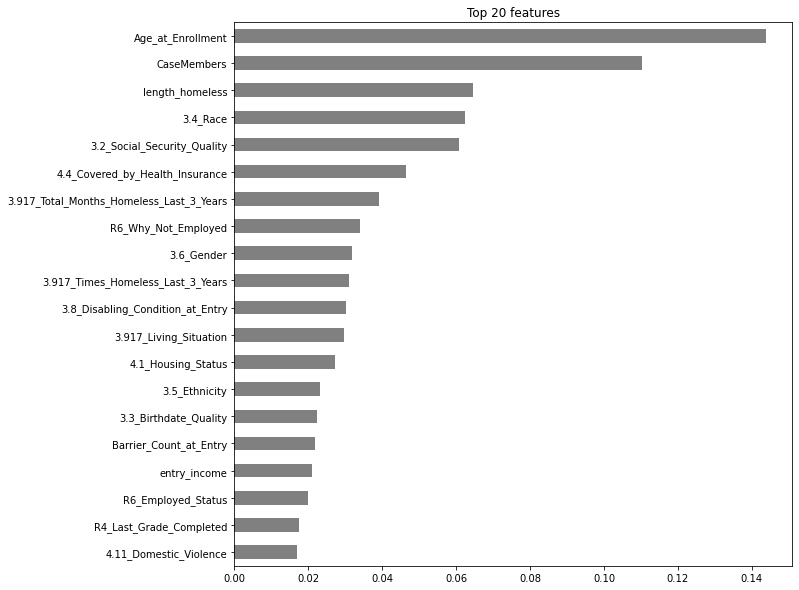

In [31]:
# get and plot feature importances

# Linear models have coefficients whereas decision trees have "Feature Importances"
import matplotlib.pyplot as plt

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_test).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [32]:
# cross validation 

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [-0.61710037 -0.63432836 -0.64552239]


In [33]:
-scores.mean()

-0.6323170393386229

Now that we have beaten the linear model with a tree based model, let us see if xgboost does a better job at predicting exit destination

In [34]:


from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_test, y_test))

Validation Accuracy: 0.703757225433526


xgboost failed to beat my tree-based model, so the tree-based model is what I will use for my prediction on my web-app

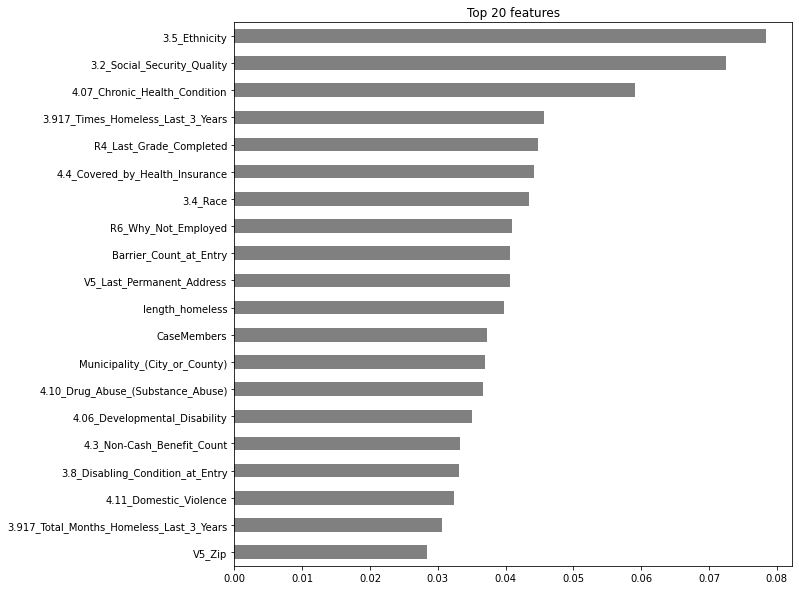

In [36]:
# get and plot feature importances

# Linear models have coefficients whereas decision trees have "Feature Importances"
import matplotlib.pyplot as plt

model = pipeline.named_steps['xgbclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_test).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');



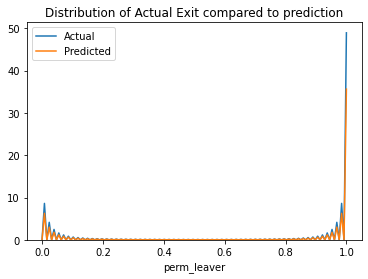

In [47]:
history = pd.read_csv('/content/n_alltime.csv')
from plotly.tools import mpl_to_plotly
import seaborn as sns
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV




# Assign to X, y to avoid data leakage
features = ['CaseMembers',
       '3.2_Social_Security_Quality', '3.3_Birthdate_Quality',
       'Age_at_Enrollment', '3.4_Race', '3.5_Ethnicity', '3.6_Gender',
       '3.7_Veteran_Status', '3.8_Disabling_Condition_at_Entry',
       '3.917_Living_Situation', 'length_homeless',
       '3.917_Times_Homeless_Last_3_Years', '3.917_Total_Months_Homeless_Last_3_Years', 
       'V5_Last_Permanent_Address', 'V5_State', 'V5_Zip', 'Municipality_(City_or_County)',
       '4.1_Housing_Status', '4.4_Covered_by_Health_Insurance', '4.11_Domestic_Violence',
       '4.11_Domestic_Violence_-_Currently_Fleeing_DV?', 'Household_Type', 
       'R4_Last_Grade_Completed', 'R5_School_Status',
       'R6_Employed_Status', 'R6_Why_Not_Employed', 'R6_Type_of_Employment',
       'R6_Looking_for_Work', 'entry_income',
       '4.3_Non-Cash_Benefit_Count', 'Barrier_Count_at_Entry',
       'Chronic_Homeless_Status', 'Under_25_Years_Old',
       '4.10_Alcohol_Abuse_(Substance_Abuse)', '4.07_Chronic_Health_Condition',
       '4.06_Developmental_Disability', '4.10_Drug_Abuse_(Substance_Abuse)',
       '4.08_HIV/AIDS', '4.09_Mental_Health_Problem',
       '4.05_Physical_Disability', 'perm_leaver'
          ]


X = history[features]
X = X.drop(columns='perm_leaver')



y_pred = pipeline.predict(X)


fig, ax = plt.subplots()
sns.distplot(test['perm_leaver'], hist=False, kde=True, ax=ax, label='Actual')
sns.distplot(y_pred, hist=False, kde=True, ax=ax, label='Predicted')
ax.set_title('Distribution of Actual Exit compared to prediction')
ax.legend().set_visible(True)


In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=42)
)

param_distributions = {
    
     
    'simpleimputer__strategy': ['most_frequent', 'mean', 'median'], 
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=1, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)




In [49]:
# Fit on train, score on val
search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [50]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy score', -search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'most_frequent', 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__bootstrap': False}
Cross-validation accuracy score -0.622389909190109


In [51]:

print('Validation Accuracy', search.score(X_test, y_test))

Validation Accuracy 0.7355491329479769


In [38]:
y_pred.shape

(1497,)

In [39]:
history['perm_leaver'].value_counts()

False    1104
True      393
Name: perm_leaver, dtype: int64

In [0]:
1282+478

1760

In [0]:
from joblib import dump
dump(pipeline, 'pipeline2.joblib', compress=True)

['pipeline2.joblib']